In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

---

<b>Read in the data</b>

In [8]:
train = pd.read_csv("CSI4810_projectVehicleData/train.csv")
target = train.pop("loan_default")
train.columns=train.columns.str.replace('.','_').str.lower()
test = pd.read_csv("CSI4810_projectVehicleData/test.csv")
test.columns=test.columns.str.replace('.','_').str.lower()

print(train.info())
print(train.describe())
counts = target.value_counts()
print(f"Percent of entries that are NOT likely to default \t{counts[0]/counts.sum() * 100:.2f}%")
print(f"Percent of entries that are likely to default\t\t{counts[1]/counts.sum() * 100:.2f}%")

C:\Users\willo_jlqcl0r\AppData\Local\Temp\ipykernel_24904\2678137221.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("CSI4810_projectVehicleData/train.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 40 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   uniqueid                             233154 non-null  int64  
 1   disbursed_amount                     233154 non-null  int64  
 2   asset_cost                           233154 non-null  int64  
 3   ltv                                  233154 non-null  float64
 4   branch_id                            233154 non-null  object 
 5   supplier_id                          233154 non-null  int64  
 6   manufacturer_id                      233154 non-null  int64  
 7   current_pincode_id                   233154 non-null  int64  
 8   date_of_birth                        233154 non-null  object 
 9   employment_type                      225493 non-null  object 
 10  disbursaldate                        233154 non-null  object 
 11  state_id     

---

#### <b>Investigation</b>

---

<b>Converting all date columns to uniform format and extracting year when necessary</b>

In [9]:
def convertDates(dates):
    dates1 = pd.to_datetime(dates[dates.str.contains("-")], dayfirst=True, format="%d-%m-%y")
    dates2 = pd.to_datetime(dates[dates.str.contains("/")], format="%m/%d/%Y")
    return pd.concat([dates1, dates2]).sort_index()

train["disbursaldate"] = convertDates(train["disbursaldate"]).dt.date
train['disbursaldate_days'] = (pd.to_datetime('01-01-2019') - pd.to_datetime(train['disbursaldate'])).dt.days

train["birth_year"] = train["date_of_birth"].str.split(r'[-/]', expand=True, regex=True).iloc[:,2].astype(int).apply(
    lambda year : (2000 + year if year == 00 else 1900 + year) if year < 100 else year)

train = train.drop(['disbursaldate','date_of_birth'],axis=1)

---

<b>Create new age feature</b><br>

age - we are adding an age column aggregated from the birth_year column to calculate approximately how old the customers are. This data was collected in 2018, so we will calculate their ages from the year 2019.


In [10]:
train['age'] = 2019 - train["birth_year"]
train=train.drop(['birth_year'],axis=1)

---

<b>Filling in null values</b><br>
The only column that has missing values is the employment_type column. For now, we will treat the missing values as their own category of unknown/unemployed. The reason I am starting with this approach is that there seems to be some relation between those born after 1995 and having a null entry in employment_type. After I select a model for prediction, I will revisit these null values to verfiy that this is the correct null handling. 

---

<b>Encoding</b><br>


In [11]:
def categorizeCreditRisk(data):
    patterns = {
        r".-very low.*":1,
        r".-low.*":2,
        r".-medium.*":3,
        r".-high.*":4,
        r".-very high.*":5,
        r"no.*":0
    }
    for pattern, replacement in patterns.items():
        data['perform_cns_score_description'] = data['perform_cns_score_description'].str.replace(pattern,
            str(replacement), regex=True,case=False)
    return data['perform_cns_score_description']

def convertyXyrsXmonColumns(column):
    df = pd.DataFrame()
    df[['years','months']] = column.str.extract(r'(\d+)yrs (\d+)mon')
    return df["years"].astype(int) * 365 + df['months'].astype(int) * 30

print(train["perform_cns_score_description"].value_counts())
train["perform_cns_score_description"] = categorizeCreditRisk(train).astype(int)

train['avg_acct_age_days'] = convertyXyrsXmonColumns(train['average_acct_age'])

train['credit_history_length_days'] = convertyXyrsXmonColumns(train['credit_history_length'])
train = train.drop(['average_acct_age','credit_history_length','branch_id'],axis=1)

train = pd.get_dummies(train)

perform_cns_score_description
No Bureau History Available                                116950
C-Very Low Risk                                             16045
A-Very Low Risk                                             14124
D-Very Low Risk                                             11358
B-Very Low Risk                                              9201
M-Very High Risk                                             8776
F-Low Risk                                                   8485
K-High Risk                                                  8277
H-Medium Risk                                                6855
E-Low Risk                                                   5821
I-Medium Risk                                                5557
G-Low Risk                                                   3988
Not Scored: Sufficient History Not Available                 3765
J-High Risk                                                  3748
Not Scored: Not Enough Info available on the c

,uniqueid,disbursed_amount,asset_cost,ltv,supplier_id,manufacturer_id,current_pincode_id,state_id,employee_code_id,mobileno_avl_flag,...,sec_instal_amt,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,no_of_inquiries,disbursaldate_days,age,avg_acct_age_days,credit_history_length_days,employment_type_Salaried,employment_type_Self employed
0,420825,50578,58400,89.55,22807,45,1441,6,1998,1,...,0,0,0,0,299,35,0,0,True,False
1,537409,47145,65550,73.23,22807,45,1502,6,1998,1,...,0,0,1,0,97,34,695,695,False,True
2,417566,53278,61360,89.63,22807,45,1497,6,1998,1,...,0,0,0,0,358,34,0,0,False,True
3,624493,57513,66113,88.48,22807,45,1501,6,1998,1,...,0,0,0,1,67,26,240,455,False,True
4,539055,52378,60300,88.39,22807,45,1495,6,1998,1,...,0,0,0,1,97,42,0,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,626432,63213,105405,60.72,20700,48,1050,6,3705,1,...,0,0,0,0,67,31,635,1185,True,False
233150,606141,73651,100600,74.95,23775,51,990,6,3705,1,...,0,0,0,0,70,31,180,180,False,True
233151,613658,33484,71212,48.45,22186,86,2299,4,3479,1,...,0,0,0,0,69,43,0,0,True,False
233152,548084,34259,73286,49.10,22186,86,2299,4,3479,1,...,0,0,0,0,94,25,0,0,True,False


---

<b>Drop columns</b><br>
The mobileno_avl_flag column has only 1 distinct value so we will drop it along with some of the columns that have been modified, the builder columns, and irrelevant columns.
Some other columns will also be dropped because they repeat data/info from other columns, irrelevant based on domain knowledge, and/or too little variation within the feature, for example, passport_flag has only 496 possitive entries which equals only .21% of the entire dataset.

In [12]:
print("Unique values in mobileno_avl_flag: ",train["mobileno_avl_flag"].unique())
train = train.drop(["mobileno_avl_flag",'uniqueid','supplier_id',
                    'employee_code_id','manufacturer_id',
                    'state_id','voterid_flag'],axis=1)

Unique values in mobileno_avl_flag:  [1]


---

#### <b>Data Visualizations</b><br>


---


Correlation Matrix

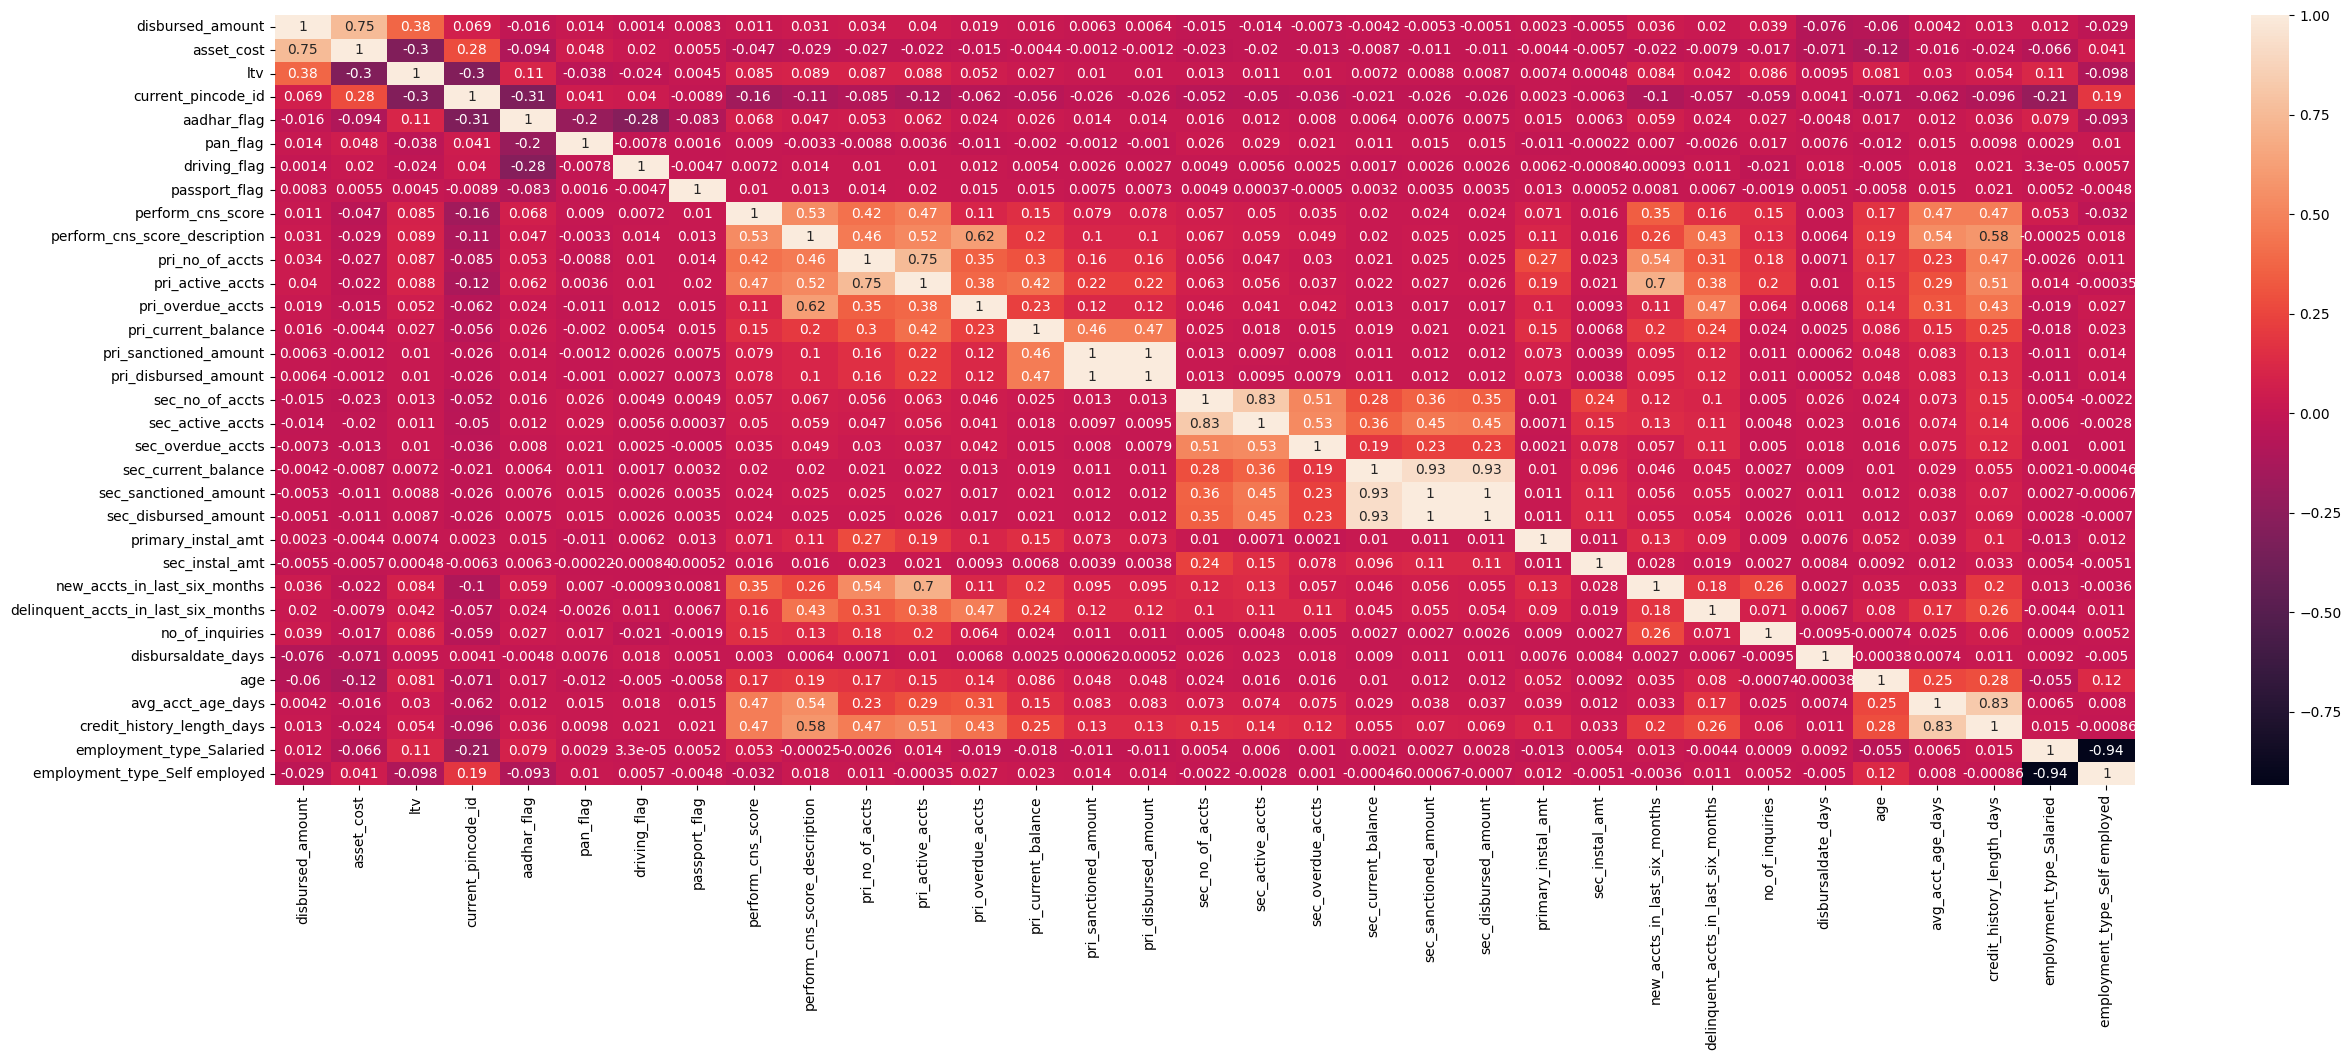

In [13]:
normalizedTrain = pd.DataFrame(StandardScaler().fit_transform(train) , columns=train.columns)

plt.figure(figsize=(30, 10))
sns.heatmap(normalizedTrain.corr(), annot=True)
plt.show()

Target Correltion Values

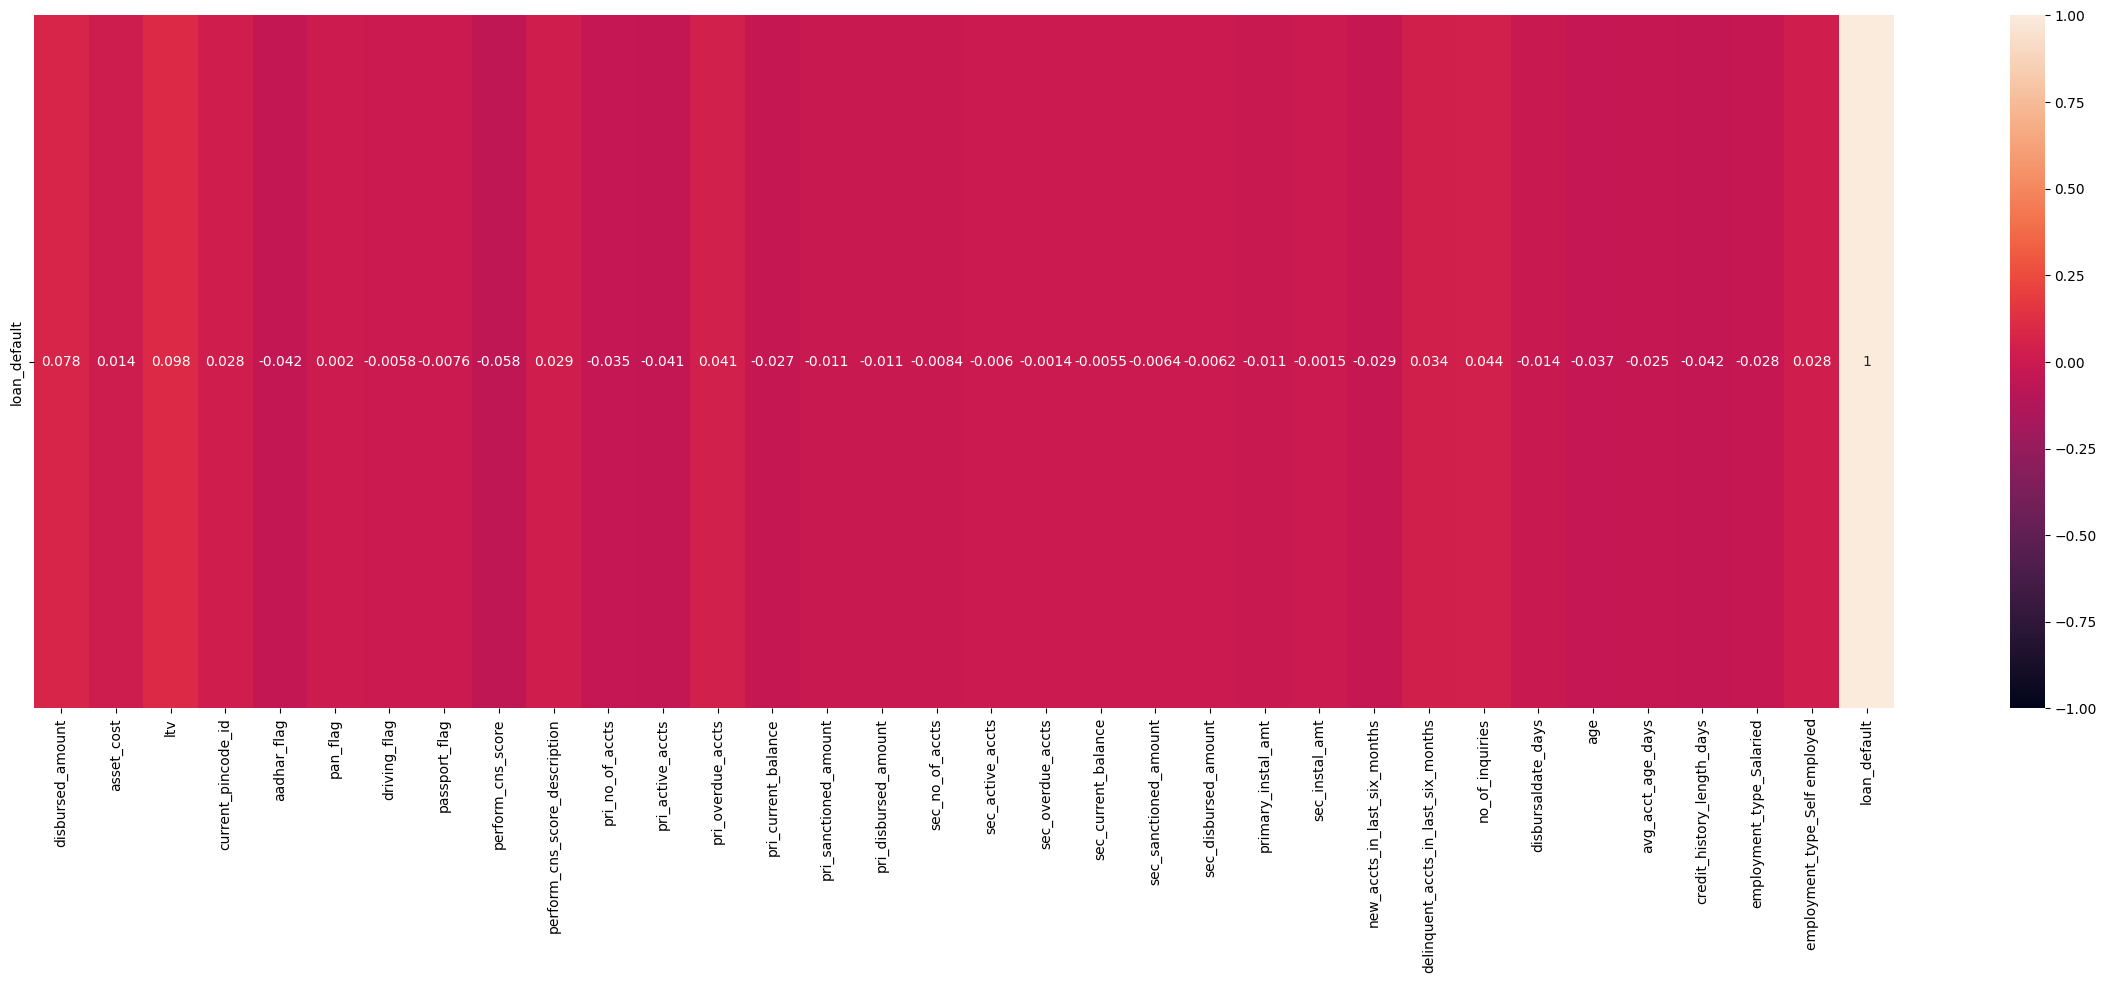

In [14]:
plt.figure(figsize=(30, 9))
sns.heatmap(pd.concat([normalizedTrain, target], axis=1).corr().loc[['loan_default']],
             annot=True,vmin=-1,vmax=1)
plt.show()

---


Histograms

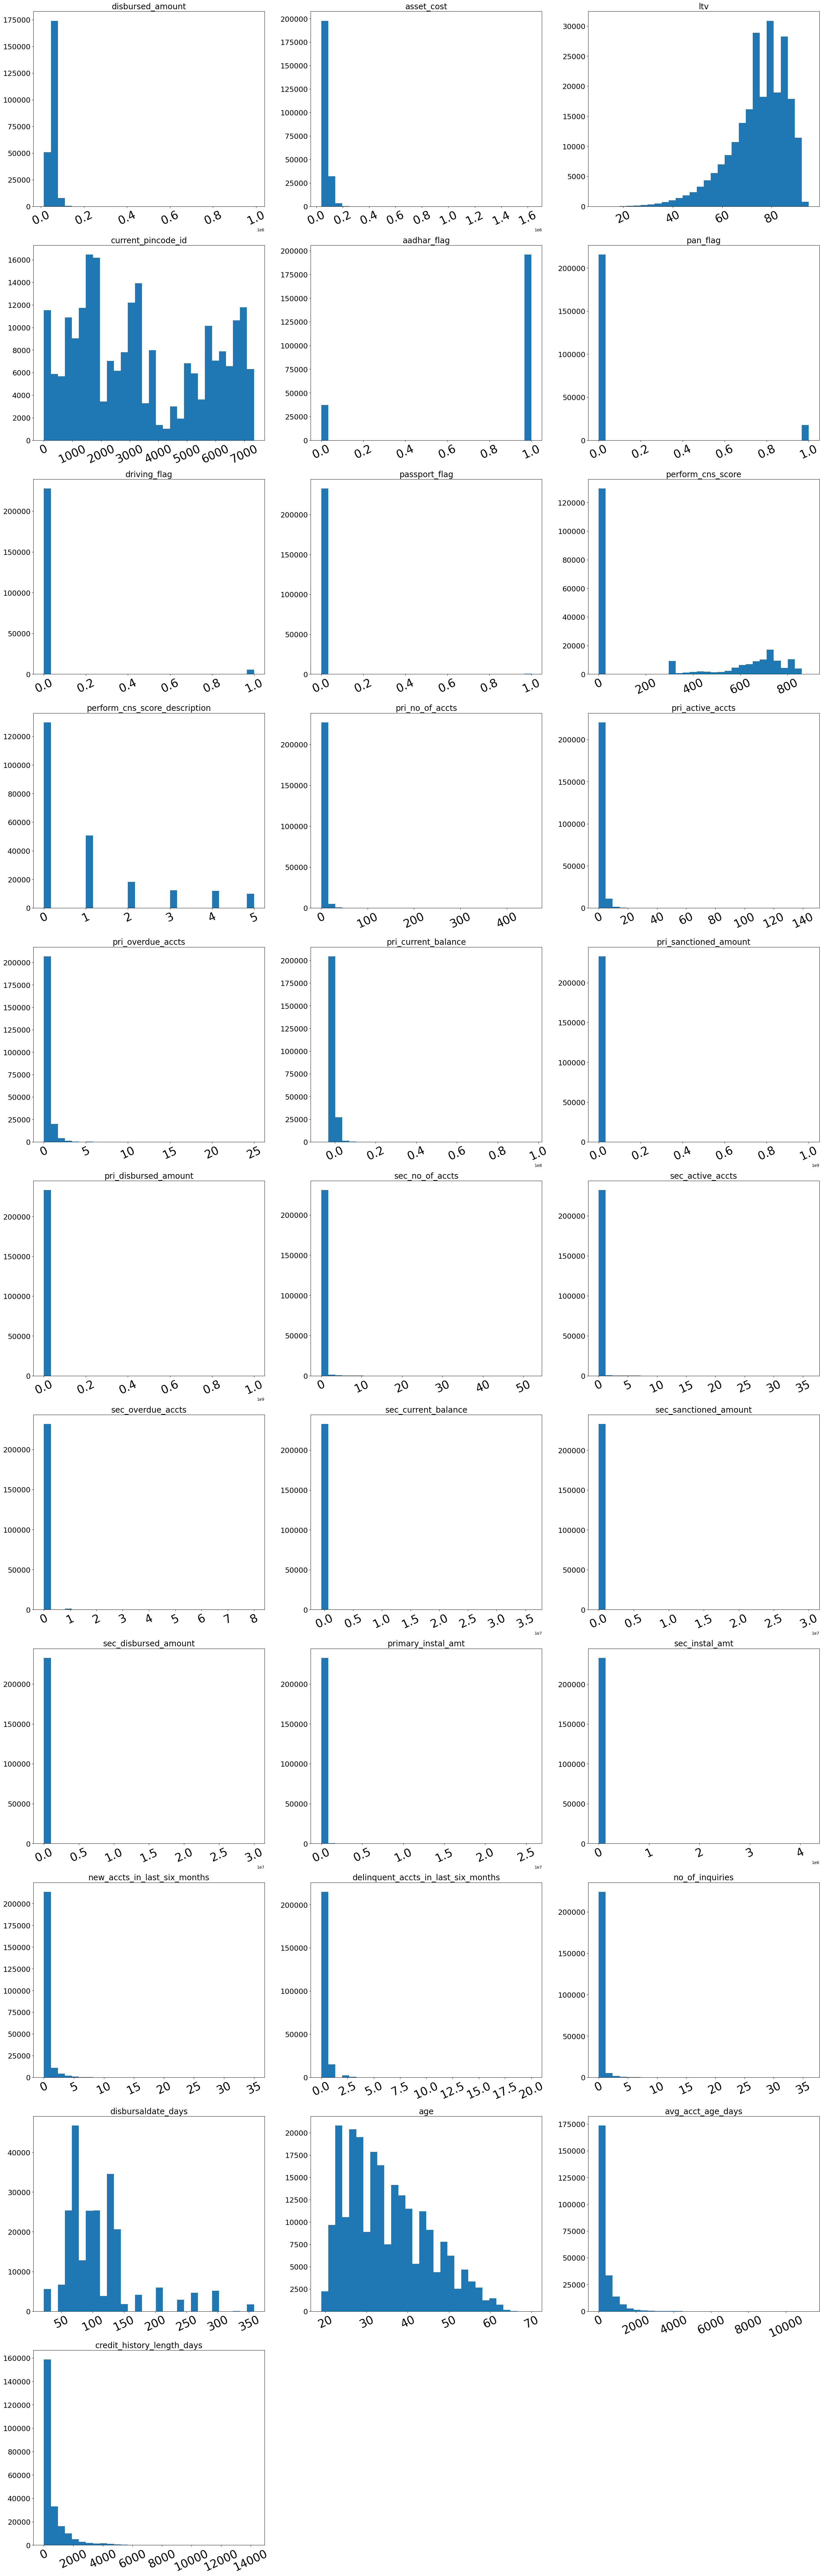

In [16]:
def visualizeHistograms(data):
    plt.figure(figsize=(35 ,230))
    for i in range(31):
        plt.subplot(11, 3, i + 1) 
        plt.subplots_adjust(bottom=.5) 
        plt.title(f"{data.columns[i]}",fontsize=20)
        if not pd.api.types.is_numeric_dtype(data.iloc[:, i]):
            data[data.columns[i]].value_counts().plot(kind='bar')
        else:
            plt.hist(train.iloc[:, i], bins=30)
        plt.xticks(fontsize=28,rotation=25)
        plt.yticks(fontsize=18)
    plt.show()

visualizeHistograms(train)

---
### Repeat for test dataset

In [ ]:
test["disbursaldate"] = convertDates(test["disbursaldate"]).dt.date
test['disbursaldate_days'] = (pd.to_datetime('01-01-2019') - pd.to_datetime(test['disbursaldate'])).dt.days

test["birth_year"] = test["date_of_birth"].str.split(r'[-/]', expand=True, regex=True).iloc[:,2].astype(int).apply(
    lambda year : (2000 + year if year == 00 else 1900 + year) if year < 100 else year)
test['age'] = 2019 - test["birth_year"]

In [19]:
test["perform_cns_score_description"] = categorizeCreditRisk(test).astype(int)

test['avg_acct_age_days'] = convertyXyrsXmonColumns(test['average_acct_age'])

test['credit_history_length_days'] = convertyXyrsXmonColumns(test['credit_history_length'])

In [20]:
test = test.drop(["mobileno_avl_flag",'supplier_id','average_acct_age',
                    'employee_code_id','branch_id','manufacturer_id',
                    'state_id','voterid_flag','disbursaldate',
                    'date_of_birth','birth_year','credit_history_length'],axis=1)

In [21]:
test = pd.get_dummies(test)

---
### Output preprocessed datasets

In [22]:
target = target.loc[train.index]
pd.concat([train, target], axis=1).to_csv("CSI4810_projectVehicleData/preprocessedTrain.csv", index=False)
test.to_csv("CSI4810_projectVehicleData/preprocessedTest.csv", index=False)